In [1]:
cd /Users/jz-rolling/Desktop/OMEGA/Notebooks/MSR_manuscript_redo/

/Users/jz-rolling/Desktop/OMEGA/Notebooks/MSR_manuscript_redo


In [2]:
import miniSAFE as ms
import numpy as np
import pickle as pk
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec as gs
import networkx as nx
from matplotlib.collections import LineCollection
import OMEGA_core as om
from scipy import stats
import seaborn as sns
import tifffile

In [3]:
# load dataframe
df = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/rep1_spikein_curated.xls')
orig_df = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/rep1_spikein.xls')

# load data
dest_folder = '/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/NMF_output/'
reshaped = np.load(dest_folder+'NMF_regrouped.npy')
h = np.load(dest_folder+'NMF_basis.npy')
w = np.load(dest_folder+'NMF_encoding.npy')
snf_data = pk.load(open('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/SNF_output/SNF_output.pk','rb'))
n_components = 20
positions = snf_data['positions']
g = snf_data['network']
pos = snf_data['embedding']
graph = snf_data['composite_graph']
func_tab = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/func_annot.xlsx',index_col='Functional_category')
msm_gff = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/start_over_once_more/references/Msm_gff.xlsx')

In [4]:
digby_data = pd.read_csv('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/digby/allClassifiedCells_final.csv')
digby_annotation = pd.read_csv('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/digby/GrowthSeqValidations_Annotated.csv',delimiter=';')

In [5]:
msm_gff.head()

,Refseq_ID,Mycobrowser_Version,Feature,Start,Stop,Score,Strand,Frame,Locus,Name,...,Is_Pseudogene,Functional_Category,Orthologues M. leprae,Orthologues M. marinum,Orthologues M. tuberculosis,Orthologues M. bovis,Orthologues M. lepromatosis,Orthologues M. tuberculosis.1,Orthologues M. abscessus,Orthologues M. haemophilum
0,NC_008596.1,Mycobrowser_v3,CDS,141740,141850,.,-,0,MSMEG_0119,MSMEG_0119,...,No,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NC_008596.1,Mycobrowser_v3,CDS,444662,444796,.,+,0,MSMEG_0395,MSMEG_0395,...,No,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NC_008596.1,Mycobrowser_v3,tRNA,6393822,6393912,.,-,0,MSMEG_6326,MSMEG_6326,...,No,stable RNAs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC_008596.1,Mycobrowser_v3,tRNA,4992841,4992927,.,-,0,MSMEG_4897,MSMEG_4897,...,No,stable RNAs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_008596.1,Mycobrowser_v3,CDS,4999233,5000252,.,-,0,MSMEG_4908,MSMEG_4908,...,No,unknown,NaN,NaN,Rv1333,NaN,NaN,Rv1333,NaN,NaN


In [10]:
digby_ref_dict = {}
for well, locus in digby_annotation[['final_id','Accession.no.']].values:
    digby_ref_dict[well]=locus
digby_ref_dict.update({'atpA':'MSMEG_4938', 'atpB':'MSMEG_4942', 
                       'atpC':'MSMEG_4935', 'atpD':'MSMEG_4936', 
                       'atpE':'MSMEG_4941', 'atpG':'MSMEG_4937', 
                       'ftsK':'MSMEG_2960','rpoB':'MSMEG_1367', 
                       'rpoC':'MSMEG_1368', 'SSB':'MSMEG_6896',
                       '01 A11':'Plasmid','01 B5':'Plasmid',
                       '01 B6':'MSMEG_1602','01 C5':'Plasmid',
                       '01 D3':'MSMEG_6393','01 D8':'Plasmid',
                       '01 F8':'MSMEG_5684','01 G7':'MSMEG_5684',
                       '02 A4':'Plasmid','02 D3':'Plasmid','02 D4':'Plasmid',
                       '02 E10':'Plasmid','01 E10':'MSMEG_2410',
                       '01 D11':'MSMEG_6928','01 D12':'MSMEG_6091',
                       '01 H12':'MSMEG_5224','02 E2':'MSMEG_6074',
                       '02 E8':'MSMEG_4623','02 E9':'MSMEG_0903',
                       '02 G3':'MSMEG_3122','03 C6':'MSMEG_4253',
                       '03 G11':'MSMEG_0974','03 G9':'MSMEG_4261',
                       '03 H12':'MSMEG_4702','03 H2':'MSMEG_6077'})

In [11]:
data_namedict = {}
for n in digby_data['EXPERIMENT'].unique():
    data_namedict[n] = digby_data[digby_data['EXPERIMENT']==n]['Name'].unique()[0]

In [12]:
curated_dict={}
for k,v in data_namedict.items():
    if k in digby_ref_dict:
        curated_dict[k] = [digby_ref_dict[k],v]
    elif v in msm_gff['Name'].values:
        curated_dict[k] = [msm_gff[msm_gff['Name']==v]['Locus'].values[0],v]
    else:
        print(k,v)

In [13]:
appendix = []
for k in digby_data['EXPERIMENT'].values:
    if k == 'Plasmid':
        appendix.append('Plasmid')
    else:
        appendix.append(curated_dict[k][0])
digby_data['Locus'] =np.array(appendix)

In [14]:
aggregated_data = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/global_metrics_reoriented_v2.0.xls')
aggregated_data['Well_id'] = ['_'.join(x.split('_')[:3]) for x in aggregated_data['key']]
reindexed = aggregated_data.set_index('Well_id')
msr_filtered = df[df['experiment']=='MSR'].copy()
msr_filtered['Well_id'] = ['_'.join(x.split('_')[:3]) for x in msr_filtered['key']]
msr_filtered[aggregated_data.columns[3:-1]] = reindexed.loc[msr_filtered['Well_id']][aggregated_data.columns[3:-1]].values
msr_filtered.to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/global_metrics_curated_filtered.xlsx')

In [446]:
shared_locus = set(msr_filtered['locus'].values)&set(digby_data[digby_data['Replica']==1]['Locus'].values)

In [447]:
digby_rep1_mean = digby_data[digby_data['Replica']==1].groupby('Locus').mean()
digby_rep1_std = digby_data[digby_data['Replica']==1].groupby('Locus').std()

In [448]:
msr_filtered_reindexed = msr_filtered.set_index('locus')
msr_shared = msr_filtered_reindexed.loc[sorted(shared_locus)]
digby_rep1_mean_shared = digby_rep1_mean.loc[sorted(shared_locus)]
digby_rep1_std_shared = digby_rep1_std.loc[sorted(shared_locus)]

In [449]:
from sklearn.preprocessing import StandardScaler
digby_merged_d = np.hstack([digby_rep1_mean_shared[digby_rep1_mean_shared.columns[1:-1]].values,
                            digby_rep1_std_shared[digby_rep1_mean_shared.columns[1:-1]].values])
#digby_merged_d = digby_rep1_mean_shared[digby_rep1_mean_shared.columns[1:-1]].values
digby_merged_z = StandardScaler().fit_transform(digby_merged_d)
digby_merged_cols = ['{}_mean'.format(x) for x in digby_rep1_mean_shared.columns[1:-1]]+\
                    ['{}_std'.format(x) for x in digby_rep1_mean_shared.columns[1:-1]]
digby_merged_df = pd.DataFrame(digby_merged_z, index=digby_rep1_mean_shared.index, columns=digby_merged_cols)
col_filtered = [x for x in digby_merged_cols if 'pole' not in x]
digby_merged_df_filtered = digby_merged_df[col_filtered].copy()

In [461]:
digby_corrM = digby_merged_df_filtered.T.corr(method='pearson').values

In [104]:
digby_data

,Unnamed: 0,SHAPE.angularity,SHAPE.angularity.amplitude,SHAPE.angularity.max,SHAPE.angularity.median,SHAPE.angularity.mid,SHAPE.angularity.min,SHAPE.angularity.stdev,SHAPE.angularity.variation,SHAPE.area,...,SHAPE.width.min,SHAPE.width.stdev,SHAPE.width.variation,EXPERIMENT,MAXIMA,Prediction,Replica,WELL_ID,Name,Locus
0,1,0.051161,0.398970,0.274429,0.041602,0.012415,0.0,0.054962,1.074279,6.026343,...,0.512399,0.090310,0.149068,01 A1,2,T,1,01 A1,aroF,MSMEG_3030
1,2,0.057170,0.498708,0.260277,0.037582,0.052485,0.0,0.061102,1.068785,6.151628,...,0.491094,0.135005,0.192211,01 A1,2,T,1,01 A1,aroF,MSMEG_3030
2,3,0.061048,0.333336,0.200479,0.046945,0.013672,0.0,0.055681,0.912076,5.195014,...,0.499088,0.061965,0.104344,01 A1,2,T,1,01 A1,aroF,MSMEG_3030
3,4,0.067276,0.459531,0.275047,0.055749,0.036004,0.0,0.063170,0.938974,4.483147,...,0.437046,0.090896,0.163771,01 A1,2,T,1,01 A1,aroF,MSMEG_3030
4,5,0.036994,0.212332,0.130848,0.029704,0.000000,0.0,0.032458,0.877370,6.714578,...,0.511376,0.164248,0.248598,01 A1,2,T,1,01 A1,aroF,MSMEG_3030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163554,163555,0.097170,0.609175,0.502265,0.046788,0.000000,0.0,0.135409,1.393523,6.575823,...,0.561881,0.078291,0.121810,SSB,2,T,1,SSB,SSB,MSMEG_6896
163555,163556,0.096373,0.454957,0.282973,0.078427,0.045610,0.0,0.075198,0.780279,6.054236,...,0.505756,0.044891,0.077262,SSB,2,T,1,SSB,SSB,MSMEG_6896
163556,163557,0.061279,0.671727,0.492256,0.037085,0.037516,0.0,0.080560,1.314628,12.488546,...,0.407180,0.087754,0.134192,SSB,4,T,1,SSB,SSB,MSMEG_6896
163557,163558,0.071289,0.500801,0.351502,0.059989,0.000000,0.0,0.062733,0.879990,8.732278,...,0.458490,0.109158,0.168637,SSB,2,T,1,SSB,SSB,MSMEG_6896


In [58]:
grouped_mean = digby_data.groupby('Locus').median()
grouned_std = digby_data.groupby('Locus').mean()

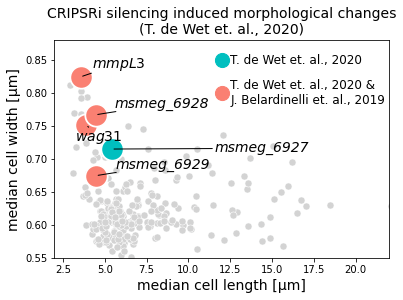

In [103]:
import adjustText
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot()
ax.set_xlim(2,22)
ax.set_ylim(0.55,0.88)
sns.scatterplot(data=grouped_mean,x='SHAPE.length',y='SHAPE.width',ax=ax)
hits = np.array(['MSMEG_0250','MSMEG_4217','MSMEG_6928','MSMEG_6929','MSMEG_6927'])
outgroup = np.array([x for x in grouped_mean.index if x not in hits])
sns.scatterplot(data=grouped_mean.loc[outgroup],x='SHAPE.length',y='SHAPE.width',ax=ax,fc='lightgrey',s=50)
sns.scatterplot(data=grouped_mean.loc[hits[:-1]],x='SHAPE.length',y='SHAPE.width',ax=ax,fc='salmon',s=500)
sns.scatterplot(data=grouped_mean.loc[np.array(['MSMEG_6927'])],x='SHAPE.length',y='SHAPE.width',ax=ax,fc='c',s=500)

hit_x,hit_y,hit_s = grouped_mean.loc[hits]['SHAPE.length'].values,\
                    grouped_mean.loc[hits]['SHAPE.width'].values,\
                    list(hits)
texts = []
for i,s in enumerate(hit_s):
    if s=='MSMEG_0250':
        texts.append(ax.text(hit_x[i],hit_y[i],'$mmpL3$',fontsize=14))
    elif s=='MSMEG_4217':
        texts.append(ax.text(hit_x[i],hit_y[i],'$wag31$',fontsize=14))
    else:
        texts.append(ax.text(hit_x[i],hit_y[i],s.lower(),fontsize=14,style='italic'))
        
ax.scatter(12,0.85,fc='c',s=200)
ax.scatter(12,0.8,fc='salmon',s=200)
ax.text(12.5,0.85,'T. de Wet et. al., 2020',ha='left',va='center',fontsize=12)
ax.text(12.5,0.8,'T. de Wet et. al., 2020 &\nJ. Belardinelli et. al., 2019',ha='left',va='center',fontsize=12)
        
adjustText.adjust_text(texts,arrowprops=dict(arrowstyle='-', color='black'),
                       force_points=(0.4,0.5),
                       force_text=(0.4,0.5),
                       expand_points=(1.4,1.5))

ax.set_xlabel('median cell length [μm]',fontsize=14)
ax.set_ylabel('median cell width [μm]',fontsize=14)
ax.set_title('CRIPSRi silencing induced morphological changes\n(T. de Wet et. al., 2020)',fontsize=14)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/digby_6928_correlation.png',dpi=120,bbox_inches='tight')

In [95]:
def genes2network(genelist,filename=None):
    import networkx as nx
    import adjustText
    fig=plt.figure(figsize=(4,4))
    ax=fig.add_subplot()
    ax.scatter(positions[0],positions[1],fc='lightgrey',ec='None',s=10,alpha=0.5)
    edges = nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.05, width=0.05, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    texts = []
    for l in genelist:
        idx,name = df[df['locus']==l][['Original_index','name']].values[0]
        if not name.startswith('MSMEG_'):
            name = name[0].capitalize()+name[1:]
        ax.scatter(positions[0,idx],positions[1,idx],fc='salmon',ec='black',s=100)
        texts.append(ax.text(positions[0,idx],positions[1,idx],name,fontsize=12))
    adjustText.adjust_text(texts)
    if filename is not None:
        plt.savefig(filename,dpi=120,bbox_inches='tight')
        plt.close()

In [98]:
genes2network(['MSMEG_0250','MSMEG_6928','MSMEG_4217','MSMEG_0736'],'/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/timelapse/6928_network.png')